# Context
This notebook drives the training process for different models.

# Context
This notebook drives the training process for different models.

In [1]:
# Set project's environment variables
import os
import sys
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../../project.env")
sys.path.append(os.environ["PYTHONPATH"])

In [2]:
# Import project-wide and PH2 specific variables and functions
import superheader as sup
import TRAIN.architecture.BERT.bert as bert

In [3]:
TRAIN_classes = 'two-classes'
top_barrier=3

In [4]:
from pathlib import Path

def get_latest_csv(directory):
  # Get all csv files in the directory
  csv_files = Path(directory).glob("*.csv")

  # Sort them by filename (timestamps are embedded)
  sorted_files = sorted(csv_files, key=lambda f: f.name)

  # Return the latest one
  return sorted_files[-1] if sorted_files else None

tinybert_spf_score_file = get_latest_csv(os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_S_PF, bert.BERT_TINY))
tinybert_spv_score_file = get_latest_csv(os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_S_PV, bert.BERT_TINY))
distilbert_spf_score_file = get_latest_csv(os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_S_PF, bert.DISTILBERT))
distilbert_spv_score_file = get_latest_csv(os.path.join(sup.TRAIN_SCORES_ROOT, TRAIN_classes, sup.TRAIN_BERT_CODE, sup.DATA_S_PV, bert.DISTILBERT))

# Score analysis

## Helper functions

In [5]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd

In [6]:
def visualize(df: pd.DataFrame, group_cols, top, filter_cols=None, filter_values=None):
  """
  Optionally filters df by filter_cols == filter_values, groups by group_cols,
  selects top `top` rows by accuracy, computes mean accuracy, and plots the result.
  """
  filter_desc = ""

  # Optional filtering
  if filter_cols and filter_values:
    for col, val in zip(filter_cols, filter_values):
      df = df[df[col] == val]
    filter_desc = " | " + " & ".join(f"{col}={val}" for col, val in zip(filter_cols, filter_values))

  if df.empty:
    print("Warning: DataFrame is empty after filtering.")
    return

  # Group + mean of top k
  def top_k_mean(g):
    top_k = g.sort_values('accuracy', ascending=False).head(top)
    if top_k.empty:
      return float('nan')  # or 0.0
    return top_k['accuracy'].mean()

  mean_accuracies = (
      df.groupby(group_cols)
        .apply(top_k_mean)
        .to_frame('mean_accuracy')
        .reset_index()
  )

  if mean_accuracies.empty:
    print("Warning: No data to plot after grouping.")
    return

  # Create labels
  mean_accuracies['label'] = mean_accuracies[group_cols].astype(str).agg(' | '.join, axis=1)

  # Plotting
  colors = sns.color_palette("muted", len(mean_accuracies))
  plt.figure(figsize=(10, 6))
  plt.bar(mean_accuracies['label'], mean_accuracies['mean_accuracy'], color=colors)

  plt.ylabel(f"Mean Accuracy (Top {top})")
  plt.title(f"Top {top} Mean Accuracies per {' + '.join(group_cols)}{filter_desc}")
  plt.xticks(rotation=45, ha='right')

  # Add y-limit padding
  min_val = mean_accuracies['mean_accuracy'].min()
  max_val = mean_accuracies['mean_accuracy'].max()
  padding = (max_val - min_val) * 0.3 if max_val > min_val else 0.1
  plt.ylim(max(min_val - padding, 0), min(max_val + padding, 1))

  # Add value labels
  for i, val in enumerate(mean_accuracies['mean_accuracy']):
    plt.text(i, val + padding * 0.002, f"{val:.3f}", ha='center', va='bottom', fontsize=9)

  plt.tight_layout()
  plt.show()


## Data

In [7]:
tinybert_spf_scores_df = pd.read_csv(tinybert_spf_score_file)
tinybert_spv_scores_df = pd.read_csv(tinybert_spv_score_file)
distilbert_spf_scores_df = pd.read_csv(distilbert_spf_score_file)
distilbert_spv_scores_df = pd.read_csv(distilbert_spv_score_file)

bert_scores_df = pd.concat([
                            tinybert_spf_scores_df,
                            tinybert_spv_scores_df, 
                            distilbert_spf_scores_df, 
                            distilbert_spv_scores_df
                            ], 
                           ignore_index=True)


bert_scores_df = bert_scores_df.fillna('None')
bert_scores_df.sort_values(by="accuracy", ascending=False)

,class_list,accuracy,data_unit,PH2,PH3,reducer,kernel,n,batch_size,loadable,num_epochs
135,two-classes,0.976744,Spv,False,False,None,None,72,1024,distilbert-base-uncased,36
127,two-classes,0.953488,Spv,False,True,pca,None,9,1024,distilbert-base-uncased,36
129,two-classes,0.953488,Spv,False,True,pca,None,11,1024,distilbert-base-uncased,36
131,two-classes,0.930233,Spv,False,True,pca,None,13,1024,distilbert-base-uncased,36
133,two-classes,0.930233,Spv,False,True,pca,None,15,1024,distilbert-base-uncased,36
...,...,...,...,...,...,...,...,...,...,...,...
113,two-classes,0.488372,Spv,True,True,umap,None,11,1024,distilbert-base-uncased,36
128,two-classes,0.488372,Spv,False,True,umap,None,9,1024,distilbert-base-uncased,36
64,two-classes,0.488372,Spv,False,True,umap,None,13,1024,prajjwal1/bert-tiny,180
103,two-classes,0.465116,Spv,True,True,umap,None,1,1024,distilbert-base-uncased,36


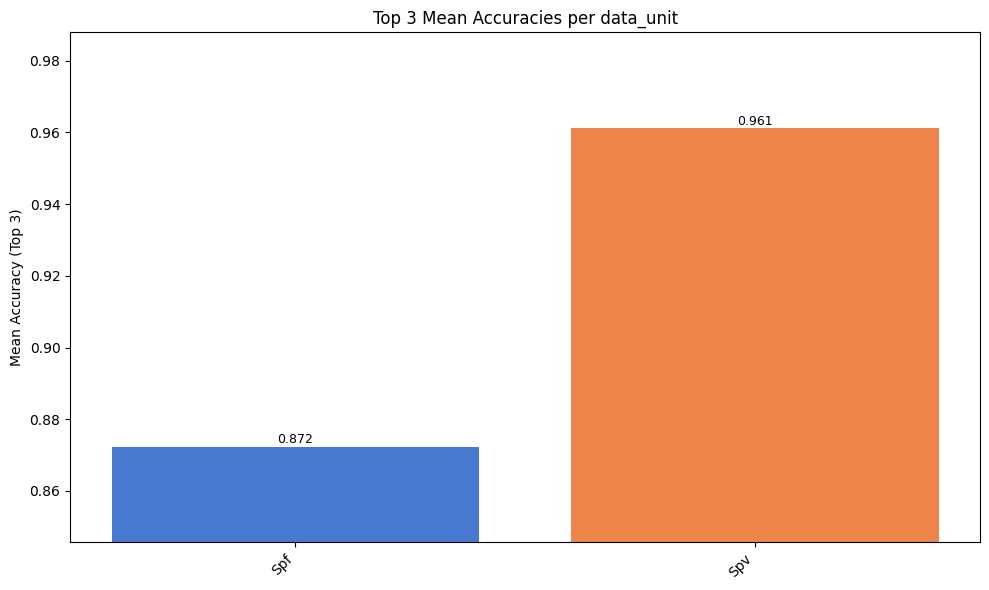

In [8]:
visualize(bert_scores_df, group_cols=['data_unit'], top=top_barrier)

### By data unit

#### Spf

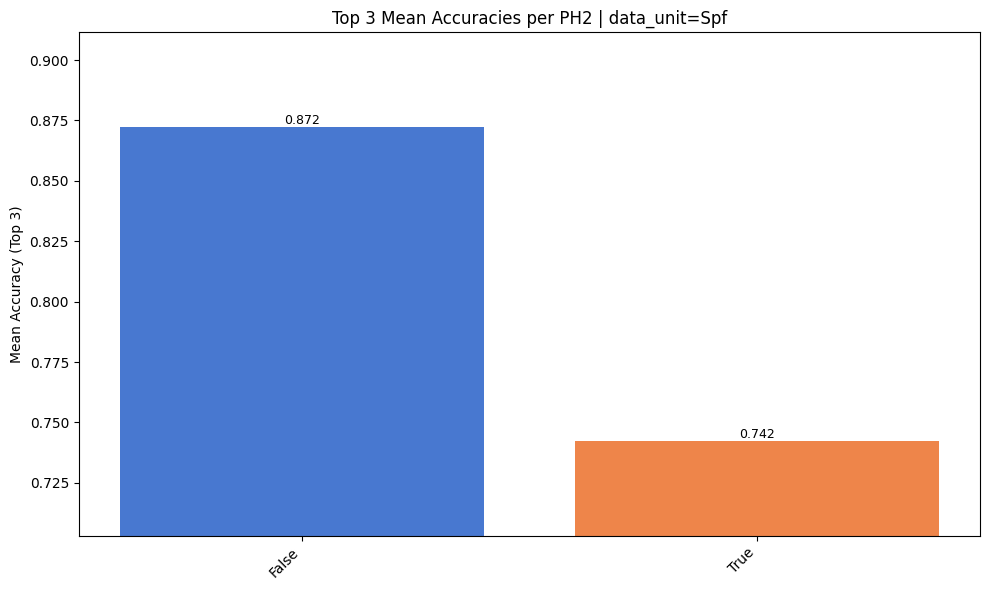

In [9]:
visualize(bert_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

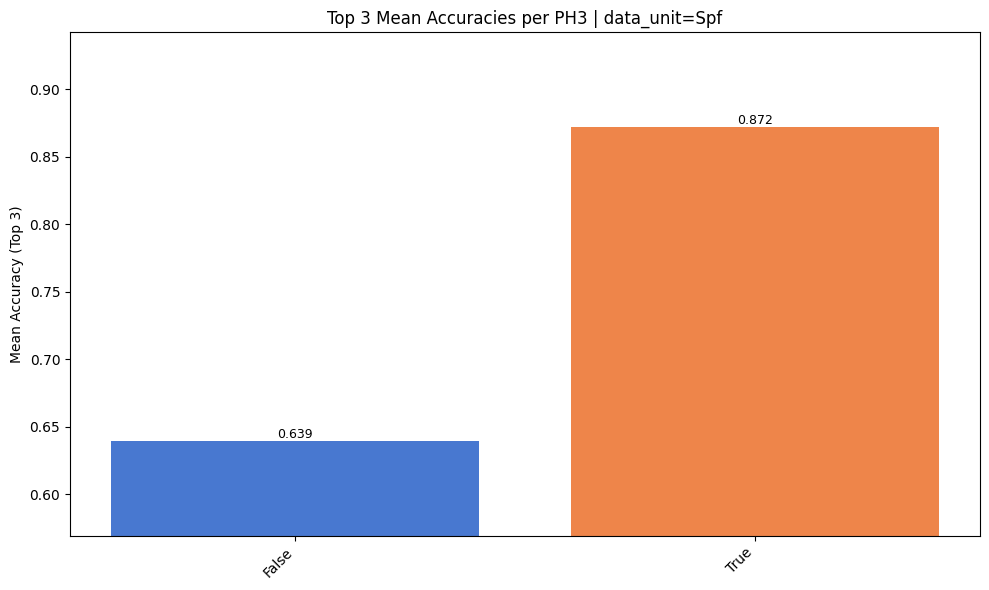

In [10]:
visualize(bert_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

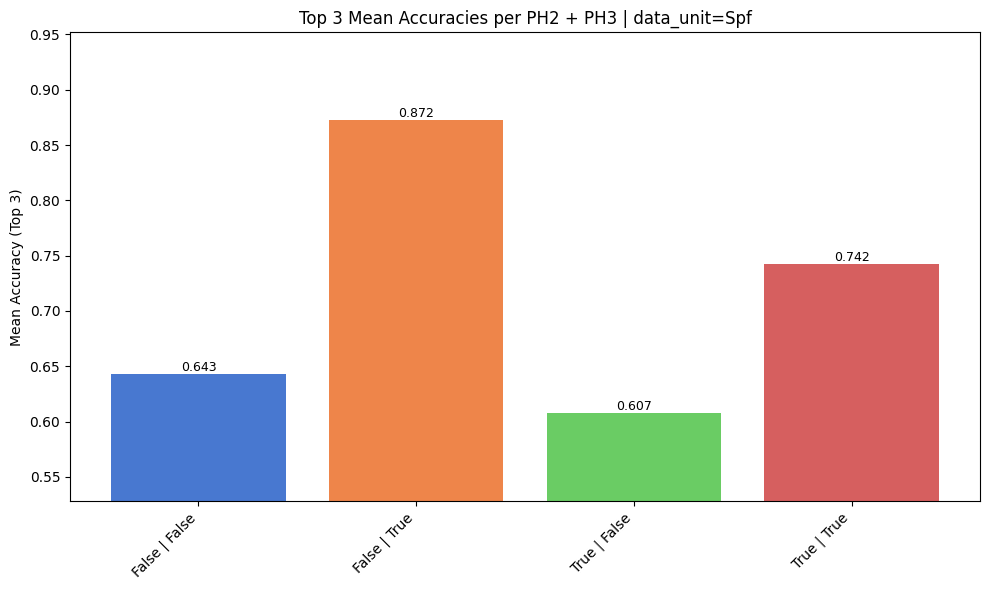

In [11]:
visualize(bert_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

#### Spv

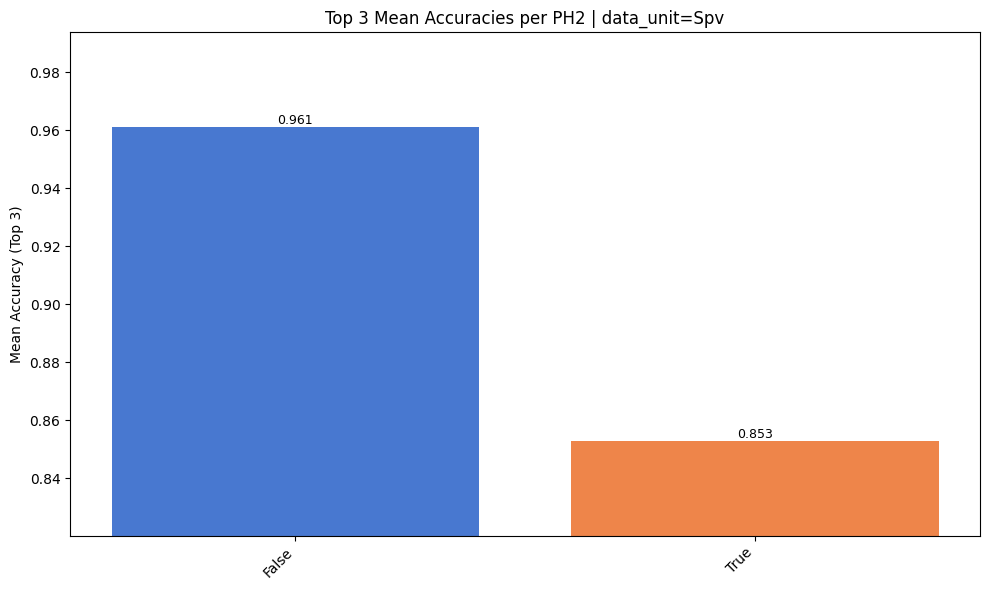

In [12]:
visualize(bert_scores_df, group_cols=['PH2'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

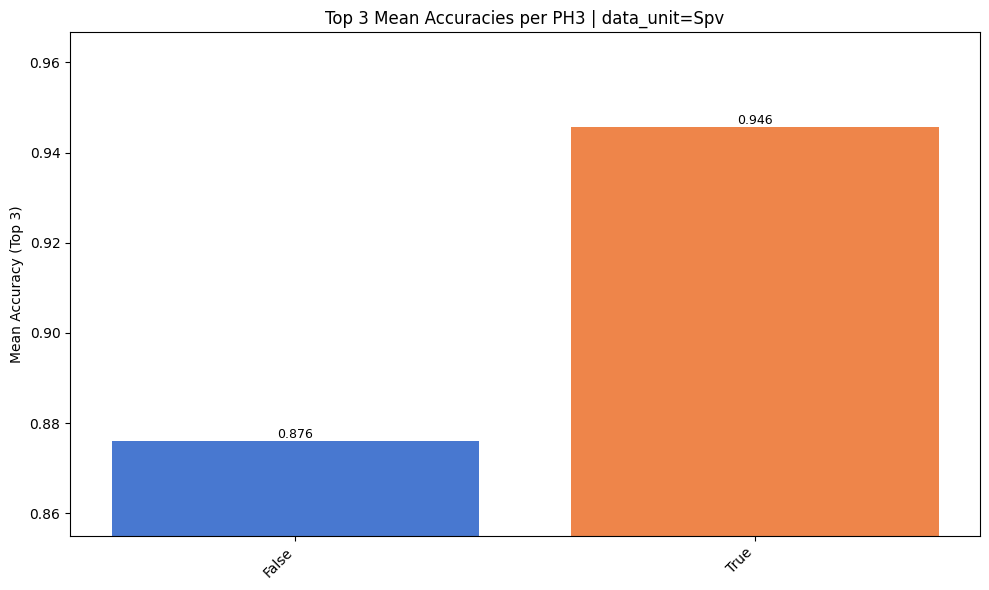

In [13]:
visualize(bert_scores_df, group_cols=['PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

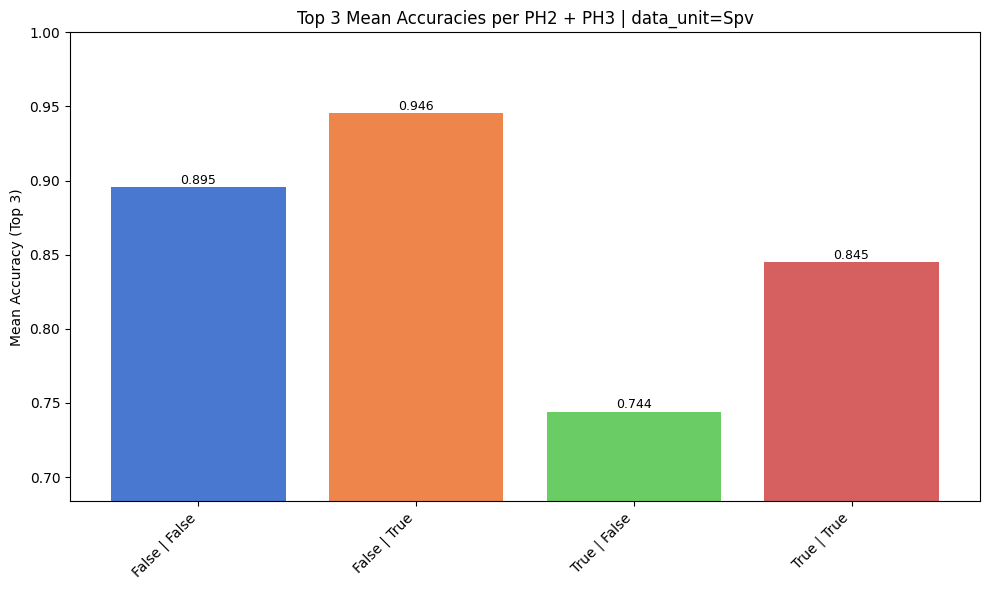

In [14]:
visualize(bert_scores_df, group_cols=['PH2', 'PH3'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By reducer

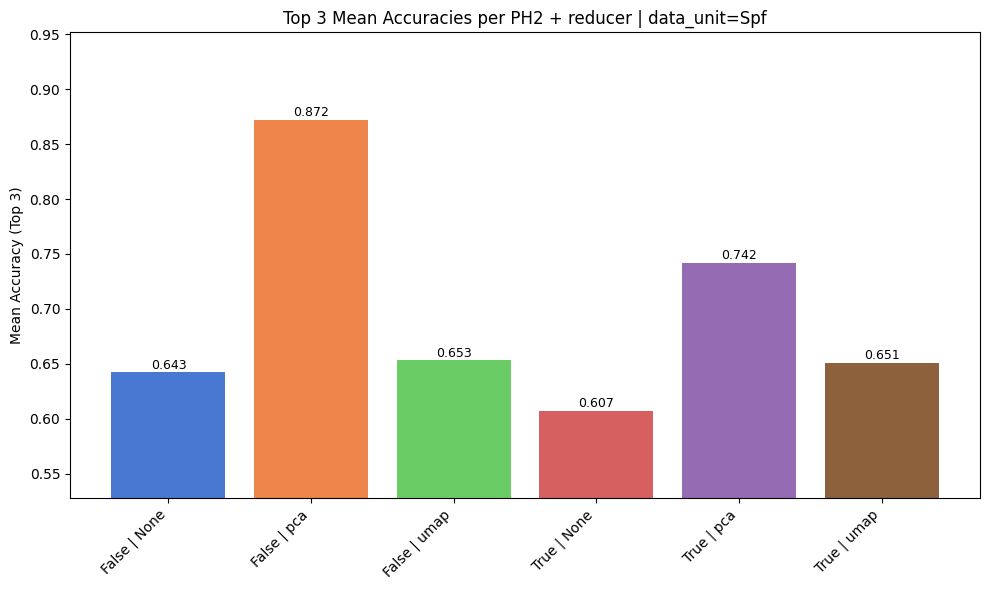

In [15]:
visualize(bert_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

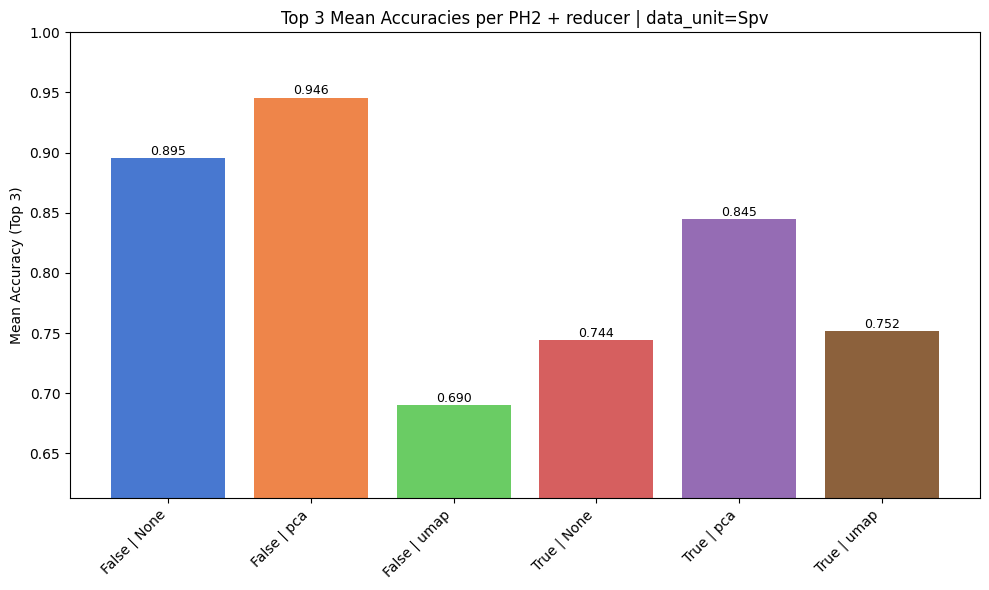

In [16]:
visualize(bert_scores_df, group_cols=['PH2', 'reducer'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])

### By number of reduction components

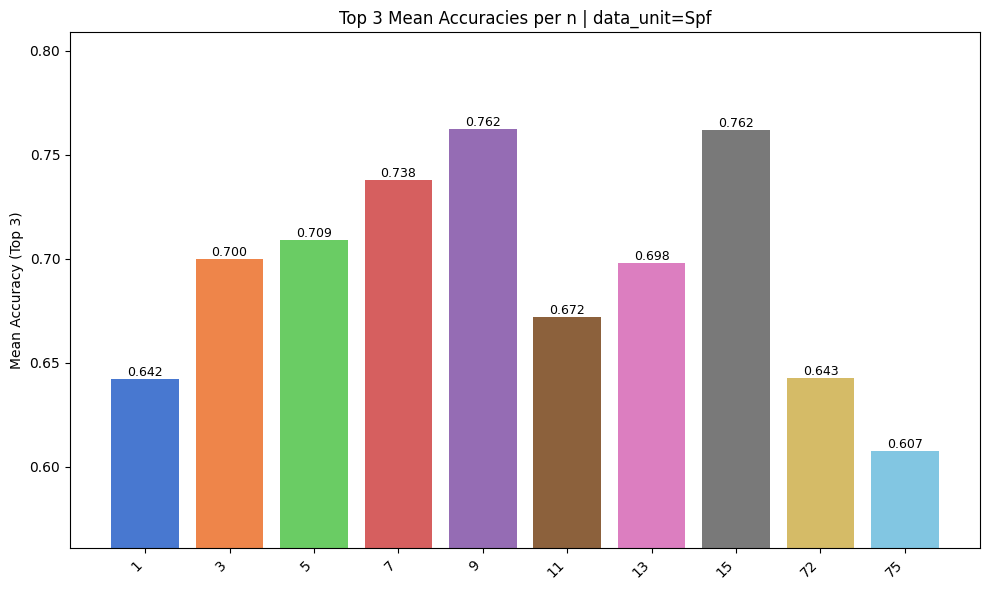

In [17]:
visualize(bert_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PF])

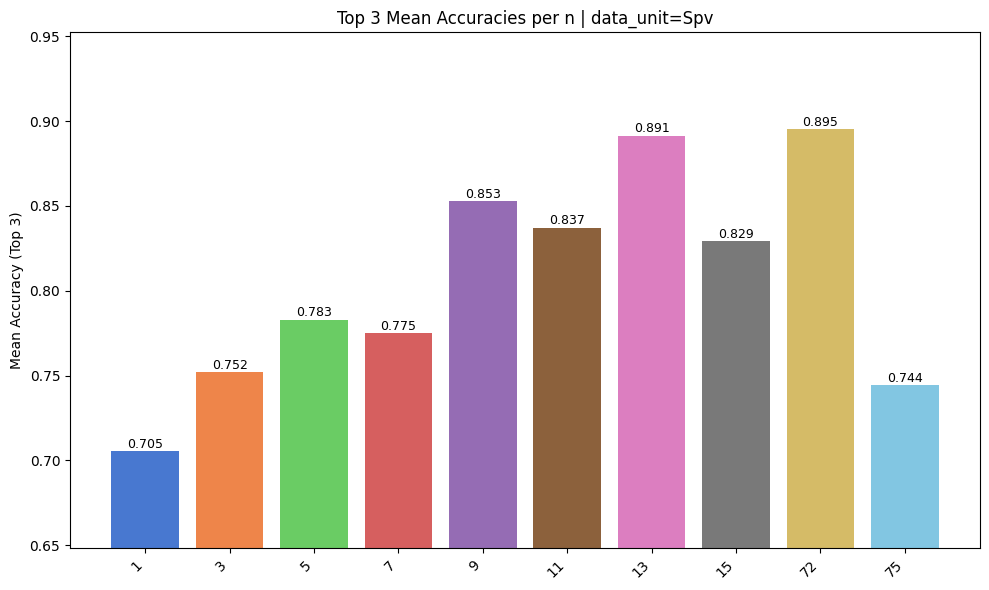

In [18]:
visualize(bert_scores_df, group_cols=['n'], top=top_barrier, filter_cols=['data_unit'], filter_values=[sup.DATA_S_PV])